# Quantum Counselor for Portfolio Investment

The Quantum Counselor for portfolio investment is a tool with two main objectives: forecasting the trend of assets price and optimizing portfolio returns both using quantum computing techniques. For the case of the forecasting method, we use a hybrid method that combines a deep learning model of classical LSTM layers with quantum layers. For the case of portfolio optimization, the quantum algorithms of QAOA and VQE are used to solve the problem and will be compared with CPLEX, a classical solver. Both tools are deeply connected because the forecasted price of the different assets is used for the cost function construction.

# Outline

1. Portfolio Optimization.


2. Stocks Selection.


3. Model XS (3 Stocks, 2 periods), QAOA and VQE with SPSA and COBYLA classical optimizers.


4. Model S  (5 Stocks, 3 periods), QAOA and VQE with SPSA and COBYLA classical optimizers.


5. Model M  (8 Stocks, 4 periods), QAOA and VQE with SPSA and COBYLA classical optimizers.


6. Novel Approach


7. References

## 1. Portfolio optimization

For portfolio optimization, we use the modern portfolio theory where we is wanted to maximize the return of an investment while keeping the risk of losing money low. We based or method in the work of Mugel et al. [<b>[1]<i>](https://doi.org/10.1103/PhysRevResearch.4.013006) where the cost function is described by:

<center><img src="images/Cost-function.png" width="800"></center>


Two main techniques:

- Portfolio optimization using QAOA, VQE, and Cplex (for classical comparison).
- Hybrid model to predict the stocks prices


Here, it is found:

- Apply the results of the Hybrid model of price prediction to optimize the portfolio.

three scenarios XS (3 stocks, 2 periods), S (5 stocks, 3 periods), M (8, 4)

The solution methods are QAOA, VQE (both in qasm_simulator and the power-up qiskit machine with 16 qubits for XS and S), CPLEX.
Using SPSA and COBYLA as classic solvers for comparison and changing the number of repetitions in QAOA and the Ansatz in VQE.
- Improving the model using the consideration, three possible actions for each stock, No invest, Medium investment, and High investment (I should use two-qubit for it and a restriction that qM(medium) + qH(high) < 1). Additionally, 
for the budget, restriction use the approach $t^2 - t$, additionally adding another risk parameter based on the uncertainity of the training stock variation prediction.

Same cases that for XS and S

In [1]:
from qiskit_finance.data_providers import RandomDataProvider
import datetime
import matplotlib.pyplot as plt
import numpy as np
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SLSQP
from qiskit_optimization.algorithms import MinimumEigenOptimizer, CplexOptimizer 
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit import IBMQ
from qiskit_optimization.runtime import QAOAClient, QAOAProgram
from qiskit.algorithms.optimizers import SPSA, COBYLA
from qiskit.circuit.library import TwoLocal
import pandas as pd
from qiskit.providers.basicaer import QasmSimulatorPy  # local simulator
from qiskit.algorithms import VQE, QAOA

import warnings
warnings.filterwarnings('ignore')

### Functions developed by the authors

In [2]:
from functions import mu_fun, cov_matrix, portfolioOptimization, Optimization_QAOA, Optimization_VQE
from functions import profits, transaction_costs

<div class="alert alert-block alert-info">
User -> Who is solving the notebook?
</div>

In [3]:
user = input()

Alejandro


In [4]:
IBMQ.load_account()
users = ["Alejandro", "Alberto"]
if user == users[0]:
    provider_7 = IBMQ.get_provider(hub='ibm-q-research', group='guanajuato-1',project='main')
    backend_7 = provider_7.get_backend("ibmq_jakarta")
elif user == users[1]:
    provider_7 = IBMQ.get_provider(hub="ibm-q-community", group="qhack-hackathon", project="7-qubit")
    provider_16 = IBMQ.get_provider(hub="ibm-q-community", group="qhack-hackathon", project="16-qubit")
    backend_7 = provider_7.get_backend("ibm_perth")
    backend_16 = provider_16.get_backend("ibmq_guadalupe")

# 2. Stocks Selection

We select 8 stocks from 8 conglomerates based on the work from Xu et al. [<b>[2]<i>](https://aclanthology.org/P18-1183/): 

- Basic Materials: TOTAL S.A. "TOT"

- Consumer Goods: Appel Inc. "AAPL"

- Healthcare: AbbVie Inc. "ABBV"

- Services: Wall-Mart Stores Inc. "WMT"

- Utilites: Duke energy corporation "DUK"

- Financial: HSBS Holding pcl "HSBC"

- Industrial Goods: ABB Ltd. "ABB"

- Technology: China Mobile Limited "CHL"

The information comes from Sep 2012 to Sep 2017 with daily Technical information of Open, High, Low, Close, Adj Close, and Volume for the stocks price. 

In [5]:
stocks_name = ["AAPL","ABB", "ABBV","CHL", "DUK", "HSBC", "TOT", "WMT"]
stocks = {}
for name in stocks_name:
    stocks[name] = np.array(pd.read_csv(f"./Data/Stocks/{name}.csv")["Close"])

In [6]:
pd.read_csv(f"./Data/Stocks/AAPL.csv")

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
1,2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2,2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
3,2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
4,2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
...,...,...,...,...,...,...,...
1253,2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000
1254,2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900
1255,2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600
1256,2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100


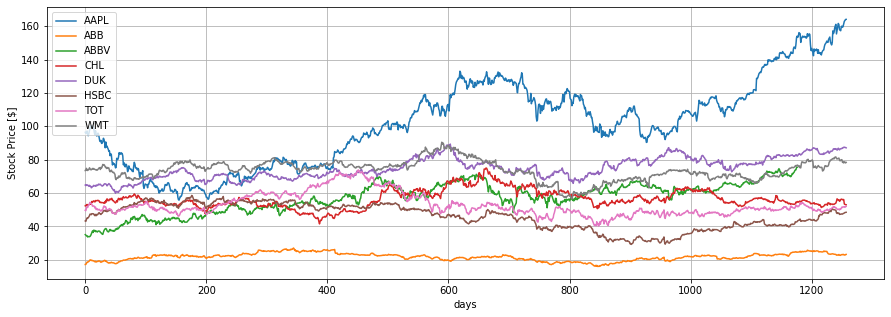

In [7]:
plt.figure(figsize=(15,5))
for i, name in enumerate(stocks_name):
    plt.plot(stocks[name], label=stocks_name[i])
plt.xlabel("days")
plt.ylabel("Stock Price [$]")
plt.legend()
plt.grid()

# 3. Optimization Model - XS

The XS model consists of 

- 3 assets "AAPL", "ABB", and "ABBV".
- 2 periods of time of 30 days. 
- Holding period of 30 days. 
- Maximum inversion per asset of 50% of the total budget.

In [8]:
xs = {}

In [9]:
# Set parameters for assets and risk factor
xs["num_assets"] = 3 # set number of assets
xs["gamma"] = 0.5   # risk aversion to 0.5
xs["lambda"] = 0.001 # Transaction Cost
xs["holding_period"] = 30 # Days of keeping the assets
xs["periods"] = 2
xs["max_investment"] = np.array([0.5, 0.5, 0.5]) # Maximum investment per asset of the total budget
xs["assets"] = ["AAPL", "ABB", "ABBV"]
xs["rho"] = 5 # Lagrange multiplier for the budget constraint 

xs["data"] = [stocks[name] for name in xs["assets"]]

xs["mu"] = mu_fun(xs["data"], xs["holding_period"])[-xs["periods"]:]
xs["sigma"] = cov_matrix(xs["data"], xs["holding_period"])
xs["qp"] = portfolioOptimization(xs["mu"], xs["sigma"][-xs["periods"]:], xs["gamma"],
                           xs["max_investment"], xs["lambda"], xs["rho"])
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
xs["qubo"] = QuadraticProgramToQubo().convert(xs["qp"])

In [10]:
xs["qubo"]

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: portfolioOptimization

Minimize
 obj: - 5.043014317244 w0_0 - 4.992270380226 w0_1 - 5.048171307303 w0_2
      - 5.023465215684 w1_0 - 5.028193441415 w1_1 - 4.997081992669 w1_2 + [
      2.501504322556 w0_0^2 + 5.000005058818 w0_0*w0_1
      + 5.000001594047 w0_0*w0_2 - 0.001000000000 w0_0*w1_0
      + 2.501513515800 w0_1^2 + 4.999999967271 w0_1*w0_2
      - 0.001000000000 w0_1*w1_1 + 2.501506688896 w0_2^2
      - 0.001000000000 w0_2*w1_2 + 2.500507758682 w1_0^2
      + 5.000009701580 w1_0*w1_1 + 4.999995156160 w1_0*w1_2
      + 2.500517070077 w1_1^2 + 4.999995360584 w1_1*w1_2 + 2.500511582019 w1_2^2
      ]/2 + 10
Subject To

Bounds
 0 <= w0_0 <= 1
 0 <= w0_1 <= 1
 0 <= w0_2 <= 1
 0 <= w1_0 <= 1
 0 <= w1_1 <= 1
 0 <= w1_2 <= 1

Binaries
 w0_0 w0_1 w0_2 w1_0 w1_1 w1_2
End

## 3.1 QAOA Solution using SPSA and COBYLA

In [11]:
xs["QAOA"] = {}

In [12]:
xs["QAOA"]["SPSA"] = Optimization_QAOA(xs["qubo"], reps=1, optimizer=SPSA(maxiter=50), local=True)

In [13]:
xs["QAOA"]["COBYLA"] = Optimization_QAOA(xs["qubo"], reps=1, optimizer=COBYLA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below execute the problem on real hardware.
</div>

In [ ]:
xs["QAOA"]["Real-COBYLA"] = Optimization_QAOA(xs["qubo"], reps=1, optimizer=COBYLA(maxiter=5),
                                                            provider=provider_7, backend=backend_7)

## 3.2 VQE Solution using SPSA and SLSQP 

In [15]:
xs["VQE"] = {}

In [16]:
xs["ansatz"] = TwoLocal(xs["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [17]:
xs["VQE"]["COBYLA"] = Optimization_VQE(xs["qubo"], ansatz=xs["ansatz"], optimizer=COBYLA(maxiter=50), local=True)

In [18]:
xs["VQE"]["SPSA"] = Optimization_VQE(xs["qubo"], ansatz=xs["ansatz"], optimizer=SPSA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below execute the problem on real hardware.
</div>

In [ ]:
xs["VQE"]["Real-COBYLA"] = Optimization_VQE(xs["qubo"], ansatz=xs["ansatz"], optimizer=COBYLA(maxiter=5),
                                             provider=provider_7, backend=backend_7)

## 3.3 Solution using CPLEX

In [19]:
xs["CPLEX"]= CplexOptimizer().solve(xs["qubo"])

## 3.4 Summary of model XS

In [20]:
np.save(f"./Data/{user}/xs.npy", xs)

#xs = np.load(f"./Data/{user}/xs.npy", allow_pickle=True).item()

In [21]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
xs_sol = [xs[met][sol][0].x.reshape(xs["periods"],-1) for met in method for sol in solver] + [xs["CPLEX"].x.reshape(xs["periods"],-1)]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[xs[met][sol][0].fval for met in method for sol in solver] + [xs["CPLEX"].fval],              
              "Solution":xs_sol,
              "Profit [%]":[np.round(100*profits(_, xs["mu"], xs["lambda"], xs["periods"], xs["max_investment"]), 1) for _ in xs_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, xs["lambda"], xs["periods"], xs["max_investment"]) for _ in xs_sol]
             })

,Method,Solver,Cost fun,Solution,Profit [%],Transaction Cost [%]
0,QAOA,SPSA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
1,QAOA,COBYLA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
2,VQE,COBYLA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
3,VQE,SPSA,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"
4,CPLEX,,-0.141321,"[[1.0, 0.0, 1.0], [1.0, 1.0, 0.0]]","[9.0, 5.1]","[0.1, 0.1]"


# 4. Optimization Model - S

The model S consists of 

- 5 assets "AAPL", "ABB", "ABBV", "CHL", and "DUK".
- 3 periods of time of 30 days. 
- Holding period of 30 days. 
- Maximum inversion per asset of 25% of the total budget.

In [22]:
s = {}

In [23]:
# Set parameters for assets and risk factor
s["num_assets"] = 5 # set number of assets
s["gamma"] = 0.5   # risk aversion to 0.5
s["lambda"] = 0.001 # Transaction Cost
s["holding_period"] = 30 # Days of keeping the assets
s["periods"] = 3
s["max_investment"] = np.array([0.25, 0.25, 0.25, 0.25, 0.25]) # Maximum investment per asset of the total budget
s["assets"] = ["AAPL", "ABB", "ABBV","CHL", "DUK"]
s["rho"] = 5 # Lagrange multiplier for the budget constraint 

s["data"] = [stocks[name] for name in s["assets"]]

s["mu"] = mu_fun(s["data"], s["holding_period"])[-s["periods"]:]
s["sigma"] = cov_matrix(s["data"], s["holding_period"])
s["qp"] = portfolioOptimization(s["mu"], s["sigma"][-s["periods"]:], s["gamma"],
                           s["max_investment"], s["lambda"], s["rho"])
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
s["qubo"] = QuadraticProgramToQubo().convert(s["qp"])

## 4.1 QAOA Solution using SPSA and COBYLA

In [24]:
s["QAOA"] = {}

In [ ]:
s["QAOA"]["SPSA"] = Optimization_QAOA(s["qubo"], reps=1, optimizer=SPSA(maxiter=50), local=True)

In [ ]:
s["QAOA"]["COBYLA"] = Optimization_QAOA(s["qubo"], reps=1, optimizer=COBYLA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below executes the problem on real hardware only available for Alberto
</div> 

In [ ]:
s["QAOA"]["Real-COBYLA"] = Optimization_QAOA(s["qubo"], reps=1, optimizer=COBYLA(maxiter=50), backend=backend_16,
                                            provider=provider_16)

## 4.2 VQE Solution using SPSA and COBYLA

In [55]:
s["VQE"] = {}
s["ansatz"] = TwoLocal(s["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [56]:
s["VQE"]["COBYLA"] = Optimization_VQE(s["qubo"], ansatz=s["ansatz"], optimizer=COBYLA(maxiter=50), local=True)

In [57]:
s["VQE"]["SPSA"] = Optimization_VQE(s["qubo"], ansatz=s["ansatz"], optimizer=SPSA(maxiter=50), local=True)

<div id='problem'></div>
<div class="alert alert-block alert-danger">
    
**WARNING** Running the code below executes the problem on real hardware only available for Alberto
</div> 

In [ ]:
s["Real-VQE"]["SPSA"] = Optimization_VQE(s["qubo"], ansatz=s["ansatz"], optimizer=COBYLA(maxiter=50), backend=backend_16,
                                            provider=provider_16)

## 4.3 Solution using CPLEX

In [74]:
s["CPLEX"]= CplexOptimizer().solve(s["qubo"])

## 4.4 Summary of model S


In [ ]:
np.save(f"./Data/{user}/s.npy", s)

#s = np.load(f"./Data/{user}/s.npy", allow_pickle=True).item()

In [79]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
s_sol = [s[met][sol][0].x.reshape(s["periods"],-1).astype(int) for met in method for sol in solver] + [(s["CPLEX"].x+0.01).reshape(s["periods"],-1).astype(int)]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[s[met][sol][0].fval for met in method for sol in solver] + [s["CPLEX"].fval],              
              "Solution":s_sol,
              "Profit [%]":[np.round(100*profits(_, s["mu"], s["lambda"], s["periods"], s["max_investment"]), 1) for _ in s_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, s["lambda"], s["periods"], s["max_investment"]) for _ in s_sol]
             })

,Method,Solver,Cost fun,Solution,Profit [%],Transaction Cost [%]
0,QAOA,SPSA,-0.164779,"[[1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 1, 0...","[8.4, 5.6, 2.5]","[0.1, 0.05, 0.05]"
1,QAOA,COBYLA,-0.156317,"[[1, 1, 0, 1, 1], [1, 1, 1, 0, 1], [1, 1, 1, 0...","[7.7, 5.4, 2.5]","[0.1, 0.05, 0.0]"
2,VQE,COBYLA,-0.156317,"[[1, 1, 0, 1, 1], [1, 1, 1, 0, 1], [1, 1, 1, 0...","[7.7, 5.4, 2.5]","[0.1, 0.05, 0.0]"
3,VQE,SPSA,-0.145200,"[[1, 1, 1, 0, 1], [1, 0, 1, 1, 1], [1, 1, 1, 0...","[6.4, 5.6, 2.5]","[0.1, 0.05, 0.05]"
4,CPLEX,,-0.164779,"[[1, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 1, 0...","[8.4, 5.6, 2.5]","[0.1, 0.05, 0.05]"


# 5. Optimization Model - M

The model M consists of 

- 8 assets "AAPL", "ABB", "ABBV", "CHL", "DUK", "HSBC", "TOT", and "WMT".
- 4 periods of time of 30 days. 
- Holding period of 30 days. 
- Maximum inversion per asset of 20% of the total budget.

In [ ]:
m = {}

In [ ]:
# Set parameters for assets and risk factor
m["num_assets"] = 8 # set number of assets
m["gamma"] = 0.5   # risk aversion to 0.5
m["lambda"] = 0.001 # Transaction Cost
m["holding_period"] = 30 # Days of keeping the assets
m["periods"] = 4
m["max_investment"] = np.array([0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]) # Maximum investment per asset of the total budget
m["assets"] = ["AAPL","ABB", "ABBV","CHL", "DUK", "HSBC", "TOT", "WMT"]
m["rho"] = 5 # Lagrange multiplier for the budget constraint 

m["data"] = [stocks[name] for name in m["assets"]]

m["mu"] = mu_fun(m["data"], m["holding_period"])[-m["periods"]:]
m["sigma"] = cov_matrix(m["data"], m["holding_period"])
m["qp"] = portfolioOptimization(m["mu"], m["sigma"][-m["periods"]:], m["gamma"],
                           m["max_investment"], m["lambda"], m["rho"])
# Create a converter from quadratic program to quadratic unconstrained binary optimization (QUBO) representation
m["qubo"] = QuadraticProgramToQubo().convert(m["qp"])

<div class="alert alert-block alert-success">
In this case, the optimization requires 32 qubits. Therefore, it is needed to run the optimization portfolio in the qasm_simulator.
    
</div>

In [ ]:
backend_sim = provider.get_backend("ibmq_qasm_simulator")

## 5.1 QAOA Solution using SPSA and COBYLA

In [ ]:
m["QAOA"] = {}

In [ ]:
m["QAOA"]["SPSA"] = Optimization_QAOA(m["qubo"], reps=1, optimizer=SPSA(maxiter=50), backend=backend_sim,
                                      provider=provider_7)

In [ ]:
m["QAOA"]["COBYLA"] = Optimization_QAOA(m["qubo"], reps=1, optimizer=COBYLA(maxiter=50), backend=backend_sim,
                                      provider=provider_7)

## 5.2 VQE Solution using SPSA and COBYLA

In [ ]:
m["VQE"] = {}
m["ansatz"] = TwoLocal(m["qubo"].get_num_vars(), rotation_blocks='ry', entanglement_blocks='cz')

In [ ]:
m["VQE"]["COBYLA"] = Optimization_VQE(m["qubo"], ansatz=m["ansatz"], optimizer=COBYLA(maxiter=50), backend=backend_sim,
                                     provider=provider_7)

In [ ]:
m["VQE"]["SPSA"] = Optimization_VQE(m["qubo"], ansatz=m["ansatz"], optimizer=SPSA(maxiter=50), backend=backend_sim,
                                   provider=provider_7)

## 5.3 Solution using CPLEX

In [ ]:
m["CPLEX"]= CplexOptimizer().solve(m["qubo"])

## 5.4 Summary of model M

In [ ]:
np.save(f"./Data/{user}/s.npy", m)

#s = np.load(f"./Data/{user}/s.npy", allow_pickle=True).item()

In [ ]:
method = ["QAOA", "VQE"]
solver = ["COBYLA", "SPSA"]
s_sol = [s[met][sol][0].x.reshape(s["periods"],-1).astype(int) for met in method for sol in solver] + [(s["CPLEX"].x+0.01).reshape(s["periods"],-1).astype(int)]
pd.DataFrame({"Method":["QAOA","QAOA", "VQE", "VQE", "CPLEX"],
              "Solver":["SPSA", "COBYLA","COBYLA", "SPSA",""],
              "Cost fun":[s[met][sol][0].fval for met in method for sol in solver] + [s["CPLEX"].fval],              
              "Solution":s_sol,
              "Profit [%]":[np.round(100*profits(_, s["mu"], s["lambda"], s["periods"], s["max_investment"]), 1) for _ in s_sol],
              "Transaction Cost [%]":[100*transaction_costs(_, s["lambda"], s["periods"], s["max_investment"]) for _ in s_sol]
             })

# 7. References
[1] Mugel, S., Kuchkovsky, C., Sánchez, E., Fernández-Lorenzo, S., Luis-Hita, J., Lizaso, E., & Orús, R. (2022). Dynamic portfolio optimization with real datasets using quantum processors and quantum-inspired tensor networks. Physical Review Research, 4(1), 1–13. https://doi.org/10.1103/PhysRevResearch.4.013006

[2] Xu, Y., & Cohen, S. B. (2018). Stock Movement Prediction from Tweets and Historical Prices. 1970–1979.